# Implementation of U2Net Model for single shot image segmentation

## Importing Libraries ⬇️

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from PIL import Image

import tensorflow as tf
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score,fbeta_score
import os
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
!pip install -q visualkeras
import visualkeras


2024-07-29 12:06:55.367813: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 12:06:55.367866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 12:06:55.369343: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class CFG:
    path='/kaggle/input/duts-saliency-detection-dataset/'
    metaFile=path+'metadata.csv'
    train_image_Dir = path+'/DUTS-TR/DUTS-TR-Image'
    test_image_Dir = path+'/DUTS-TE/DUTS-TE-Image'
    train_Mask_Dir = path+'/DUTS-TR/DUTS-TR-Mask'
    test_Mask_Dir = path+'/DUTS-TE/DUTS-TE-Mask'
    imageSize = 256

In [3]:
meta = pd.read_csv(CFG.metaFile)
meta.head()

,image_id,split,image_path,mask_path
0,ILSVRC2012_test_00000003,test,DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00000003...,DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00000003.png
1,ILSVRC2012_test_00000004,train,DUTS-TR/DUTS-TR-Image/ILSVRC2012_test_00000004...,DUTS-TR/DUTS-TR-Mask/ILSVRC2012_test_00000004.png
2,ILSVRC2012_test_00000018,train,DUTS-TR/DUTS-TR-Image/ILSVRC2012_test_00000018...,DUTS-TR/DUTS-TR-Mask/ILSVRC2012_test_00000018.png
3,ILSVRC2012_test_00000019,train,DUTS-TR/DUTS-TR-Image/ILSVRC2012_test_00000019...,DUTS-TR/DUTS-TR-Mask/ILSVRC2012_test_00000019.png
4,ILSVRC2012_test_00000022,train,DUTS-TR/DUTS-TR-Image/ILSVRC2012_test_00000022...,DUTS-TR/DUTS-TR-Mask/ILSVRC2012_test_00000022.png


In [4]:
train_images = sorted(os.listdir(CFG.train_image_Dir))
test_images = sorted(os.listdir(CFG.test_image_Dir))
train_masks = sorted(os.listdir(CFG.train_Mask_Dir))
test_masks = sorted(os.listdir(CFG.test_Mask_Dir))

## Image Loading and Processing

In [5]:
def load_img(path):
    try:
        img=Image.open(path)
        return img
    except Exception as e:
        print("Caught Exception :",e)
        return None

In [6]:
def load_data(paths,image_size=256, gray= False):
    data=[]
    try:
        for image in tqdm(paths):
            if image.split("/")[-1] in ['3048.jpg','0.jpg',"2.jpg","3048.png","0.png","2.png"]:
                continue
            else:
                img = load_img(image)
                if gray:
                    img = img.convert("L")
                img = img.resize((image_size, image_size))
                img_array = np.array(img)
                if gray:
                    img_array = img_array.reshape((image_size, image_size, 1))
            data.append(img_array)
        return np.array(data)
    except Exception as e:
        print("Caught Expection : ",e)
        
        

In [7]:
X_train_images = load_data([CFG.train_image_Dir+ '/' +x for x in train_images])

100%|██████████| 10553/10553 [00:43<00:00, 242.27it/s]


In [8]:
X_test_images = load_data([CFG.test_image_Dir+ '/' +x for x in test_images])

100%|██████████| 5019/5019 [00:23<00:00, 210.87it/s]


In [9]:
y_train_images = load_data(paths=[CFG.train_Mask_Dir+ '/' +x for x in train_masks],gray=True)/255.0

100%|██████████| 10553/10553 [00:26<00:00, 404.44it/s]


In [10]:
y_test_images = load_data(paths=[CFG.test_Mask_Dir+ '/' +x for x in test_masks],gray=True)/255.0

100%|██████████| 5019/5019 [00:13<00:00, 371.85it/s]


In [11]:
X_train_images.shape, y_train_images.shape , X_test_images.shape, y_test_images.shape

((10553, 256, 256, 3),
 (10553, 256, 256, 1),
 (5019, 256, 256, 3),
 (5019, 256, 256, 1))

In [12]:
def plot(image,mask,predicted_mask=np.array([])):
    axis=2
    plt.figure(figsize=(10,3))
    if predicted_mask.any():
        plt.suptitle('Plotting Predictions')
        axis=3
        plt.subplot(1,axis,3)
        plt.title("Predicted Mask")
        plt.imshow(predicted_mask,cmap='gray')
    
    plt.subplot(1,axis,1)
    plt.title("Orignal Image")
    plt.imshow(image,cmap='gray')
    
    plt.subplot(1,axis,2)
    plt.title("Mask Image")
    plt.imshow(mask,cmap='gray')
    
    plt.tight_layout()

#### Plotting initial Images

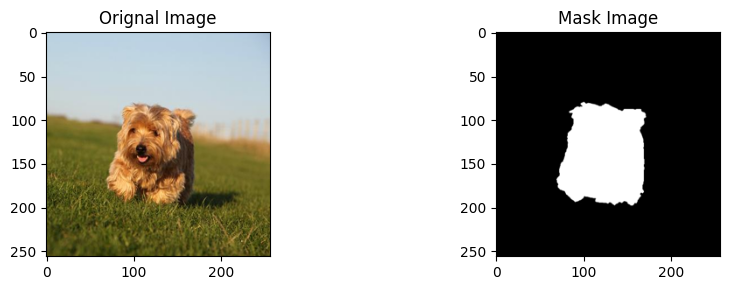

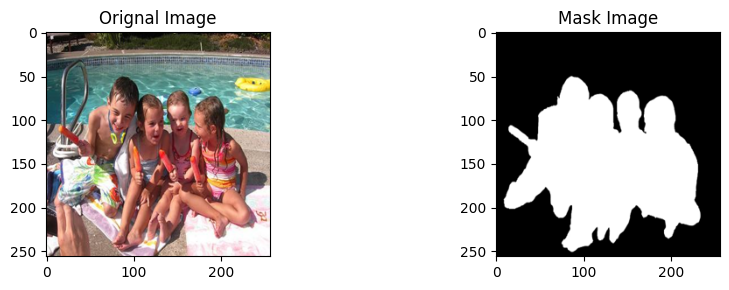

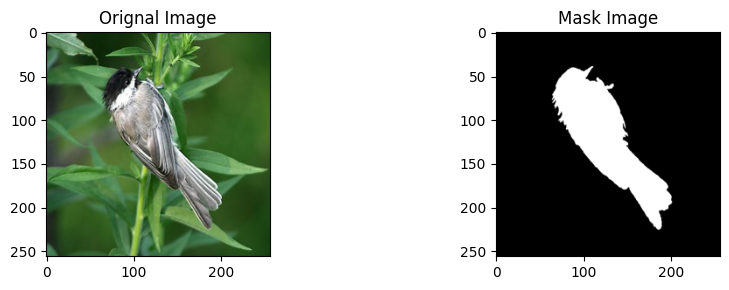

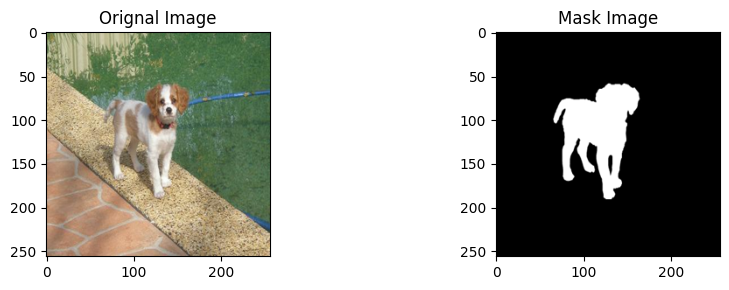

In [13]:
for i in range(4):
    plot(X_train_images[i],y_train_images[i])

### Model Construction ⚒️🏗️

In [14]:
def conv_block(shape, out_ch, rate=1):
    x = tf.keras.layers.Conv2D(out_ch, 3, padding="same", dilation_rate=1)(shape)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


In [15]:
def RSU_L(shape, out_ch, M_ch, num_layers, rate=2):
    x = conv_block(shape, out_ch)
    inp_ch = x

    skip_features = []
    x = conv_block(x, M_ch)
    skip_features.append(x)

    for i in range(num_layers-2):
        x = tf.keras.layers.MaxPool2D((2, 2))(x)
        x = conv_block(x, M_ch)
        skip_features.append(x)
        
    x = conv_block(x, M_ch, rate=rate)
    skip_features.reverse()
    x = tf.keras.layers.Concatenate()([x, skip_features[0]])
    x = conv_block(x, M_ch)

    for i in range(num_layers-3):
        x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
        x = tf.keras.layers.Concatenate()([x, skip_features[i+1]])
        x = conv_block(x, M_ch)

    x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = tf.keras.layers.Concatenate()([x, skip_features[-1]])
    x = conv_block(x, out_ch)

    x = tf.keras.layers.Add()([x, inp_ch])
    return x


In [16]:

def RESU_4F(shape, out_ch, M_ch):
    x0 = conv_block(shape, out_ch, rate=1)

    x1 = conv_block(x0, M_ch, rate=1)
    x2 = conv_block(x1, M_ch, rate=2)
    x3 = conv_block(x2, M_ch, rate=4)

    x4 = conv_block(x3, M_ch, rate=8)

    x = tf.keras.layers.Concatenate()([x4, x3])
    x = conv_block(x, M_ch, rate=4)

    x = tf.keras.layers.Concatenate()([x, x2])
    x = conv_block(x, M_ch, rate=2)

    x = tf.keras.layers.Concatenate()([x, x1])
    x = conv_block(x, out_ch, rate=1)

    x = tf.keras.layers.Add()([x, x0])
    return x
    

In [17]:

def u2net(shape, out_ch, M_ch, num_classes=1):
    inputs = tf.keras.layers.Input(shape)

    e1 = RSU_L(inputs, out_ch[0], M_ch[0], 7)
    p1 = tf.keras.layers.MaxPool2D((2, 2))(e1)

    e2 = RSU_L(p1, out_ch[1], M_ch[1], 6)
    p2 = tf.keras.layers.MaxPool2D((2, 2))(e2)

    e3 = RSU_L(p2, out_ch[2], M_ch[2], 5)
    p3 = tf.keras.layers.MaxPool2D((2, 2))(e3)

    e4 = RSU_L(p3, out_ch[3], M_ch[3], 4)
    p4 = tf.keras.layers.MaxPool2D((2, 2))(e4)
    
    e5 = RESU_4F(p4, out_ch[4], M_ch[4])
    p5 = tf.keras.layers.MaxPool2D((2, 2))(e5)

    b1 = RESU_4F(p5, out_ch[5], M_ch[5])
    b2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(b1)

    d1 = tf.keras.layers.Concatenate()([b2, e5])
    d1 = RESU_4F(d1, out_ch[6], M_ch[6])
    u1 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d1)

    d2 = tf.keras.layers.Concatenate()([u1, e4])
    d2 = RSU_L(d2, out_ch[7], M_ch[7], 4)
    u2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d2)

    d3 = tf.keras.layers.Concatenate()([u2, e3])
    d3 = RSU_L(d3, out_ch[8], M_ch[8], 5)
    u3 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d3)
    
    d4 = tf.keras.layers.Concatenate()([u3, e2])
    d4 = RSU_L(d4, out_ch[9], M_ch[9], 6)
    u4 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d4)

    d5 = tf.keras.layers.Concatenate()([u4, e1])
    d5 = RSU_L(d5, out_ch[10], M_ch[10], 7)

    
    y1 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d5)

    y2 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d4)
    y2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(y2)

    y3 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d3)
    y3 = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(y3)

    y4 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d2)
    y4 = tf.keras.layers.UpSampling2D(size=(8, 8), interpolation="bilinear")(y4)

    y5 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d1)
    y5 = tf.keras.layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(y5)
    
    y6 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(b1)
    y6 = tf.keras.layers.UpSampling2D(size=(32, 32), interpolation="bilinear")(y6)

    y0 = tf.keras.layers.Concatenate()([y1, y2, y3, y4, y5, y6])
    y0 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(y0)

    y0 = tf.keras.layers.Activation("sigmoid")(y0)
    y1 = tf.keras.layers.Activation("sigmoid")(y1)
    y2 = tf.keras.layers.Activation("sigmoid")(y2)
    y3 = tf.keras.layers.Activation("sigmoid")(y3)
    y4 = tf.keras.layers.Activation("sigmoid")(y4)
    y5 = tf.keras.layers.Activation("sigmoid")(y5)
    y6 = tf.keras.layers.Activation("sigmoid")(y6)

    model = tf.keras.models.Model(inputs, outputs=y0, name="U2-Net")
    return model

In [18]:
def build_u2net(input_shape, num_classes=1):
    out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    M_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    model = u2net(input_shape, out_ch, M_ch, num_classes=num_classes)
    return model
u2net_model = build_u2net((CFG.imageSize, CFG.imageSize, 3))

#### Training Parameters

In [19]:
def loss(y_true,y_pred):
    y_true=K.cast(y_true,'float32')
    y_pred=K.cast(y_pred,'float32')
    return tf.keras.losses.binary_crossentropy(y_true,y_pred)

def precision(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_f, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=0.3):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

 
    p = precision(y_true_f, y_pred_f)
    r = recall(y_true_f, y_pred_f)
    fbeta_score = (1 + beta) * (p * r) / (beta * p + r + K.epsilon())
    return fbeta_score


def maes(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    maes = tf.abs(y_true_f - y_pred_f)
    return maes

    

In [20]:
loss_init = loss
metrics = [maes,precision,recall,fbeta_score]

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
u2net_model.compile(optimizer=opt, loss=loss_init, metrics=metrics)

In [22]:
def get_callbacks():
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    checkpoint = tf.keras.callbacks.ModelCheckpoint('SOD.keras',verbose=1, save_best_only= True)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    return [reduce_lr, checkpoint, early_stop]

In [23]:
history = u2net_model.fit(X_train_images, y_train_images,validation_data=(X_test_images,y_test_images),
                          validation_split = 0.2,batch_size = 8, epochs = 20, callbacks=get_callbacks())

Epoch 1/20


2024-07-29 12:10:37.311427: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.72144, expected 2.89031
2024-07-29 12:10:37.311495: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.65806, expected 4.82693
2024-07-29 12:10:37.311506: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.98376, expected 5.15263
2024-07-29 12:10:37.311514: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.6283, expected 5.79717
2024-07-29 12:10:37.311533: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.90088, expected 6.06975
2024-07-29 12:10:37.311547: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.70007, expected 5.86894
2024-07-29 12:10:37.311555: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.75339, expected 4.92226
2024-07-29 12:10:37.311563: E external/local_xla/xla/ser

1319/1320 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - fbeta_score: 0.7103 - loss: 0.3585 - maes: 0.2090 - precision: 0.7267 - recall: 0.6878

2024-07-29 12:18:09.839422: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.86272, expected 2.0465
2024-07-29 12:18:09.839493: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.04967, expected 3.23345
2024-07-29 12:18:09.839503: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.4326, expected 3.61638
2024-07-29 12:18:09.839511: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.46868, expected 4.65247
2024-07-29 12:18:09.839519: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.37814, expected 4.56193
2024-07-29 12:18:09.839537: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.18374, expected 4.36753
2024-07-29 12:18:09.839545: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.54872, expected 4.7325
2024-07-29 12:18:09.839553: E external/local_xla/xla/servi

1320/1320 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - fbeta_score: 0.7104 - loss: 0.3585 - maes: 0.2090 - precision: 0.7267 - recall: 0.6878

2024-07-29 12:20:13.664132: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.23283, expected 2.3641
2024-07-29 12:20:13.664189: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.64338, expected 3.77466
2024-07-29 12:20:13.664199: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.22613, expected 4.3574
2024-07-29 12:20:13.664209: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.62769, expected 4.75897
2024-07-29 12:20:13.664217: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.08293, expected 5.2142
2024-07-29 12:20:13.664224: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.17534, expected 5.30661
2024-07-29 12:20:13.664232: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.74108, expected 4.87236
2024-07-29 12:20:13.664240: E external/local_xla/xla/servi


Epoch 1: val_loss improved from inf to 0.34622, saving model to SOD.keras
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 671s 383ms/step - fbeta_score: 0.7104 - loss: 0.3584 - maes: 0.2089 - precision: 0.7268 - recall: 0.6879 - val_fbeta_score: 0.5142 - val_loss: 0.3462 - val_maes: 0.1953 - val_precision: 0.4801 - val_recall: 0.7242 - learning_rate: 1.0000e-04
Epoch 2/20
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - fbeta_score: 0.8403 - loss: 0.2095 - maes: 0.1223 - precision: 0.8466 - recall: 0.8322
Epoch 2: val_loss improved from 0.34622 to 0.27971, saving model to SOD.keras
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 410s 310ms/step - fbeta_score: 0.8403 - loss: 0.2095 - maes: 0.1223 - precision: 0.8466 - recall: 0.8323 - val_fbeta_score: 0.5929 - val_loss: 0.2797 - val_maes: 0.1512 - val_precision: 0.5792 - val_recall: 0.6864 - learning_rate: 1.0000e-04
Epoch 3/20
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - fbeta_score: 0.8656 - loss: 0.1764 - maes: 0.1010 - precision: 0.8696 - recall: 0.8630
Epoch 3: va

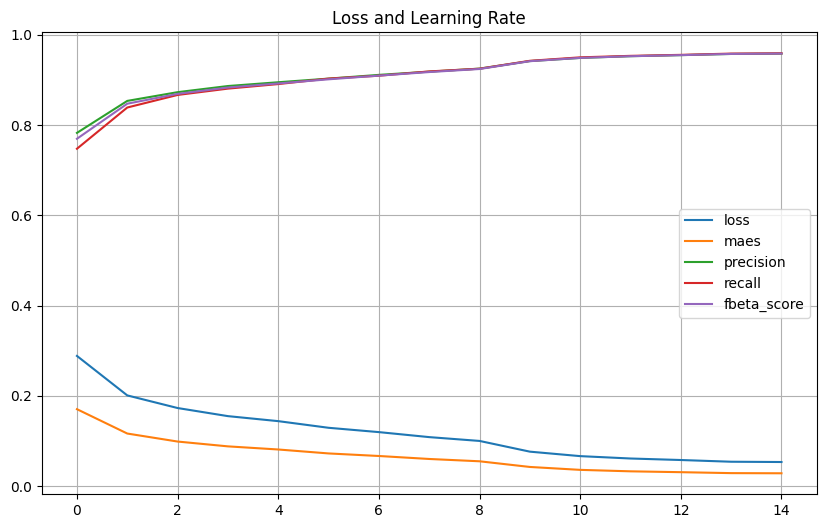

In [26]:
plt.figure(figsize=(10,6))
plt.title("Loss and Learning Rate")
plt.plot(history.history['loss'])
plt.plot(history.history['maes'])
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['fbeta_score'])
plt.grid()
plt.legend(['loss','maes','precision','recall','fbeta_score'])
plt.show()

## Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


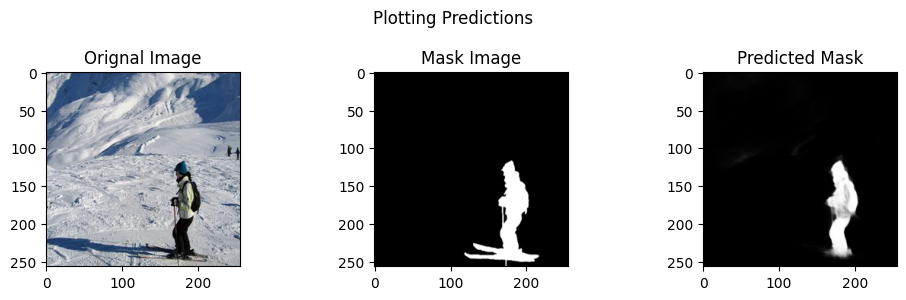

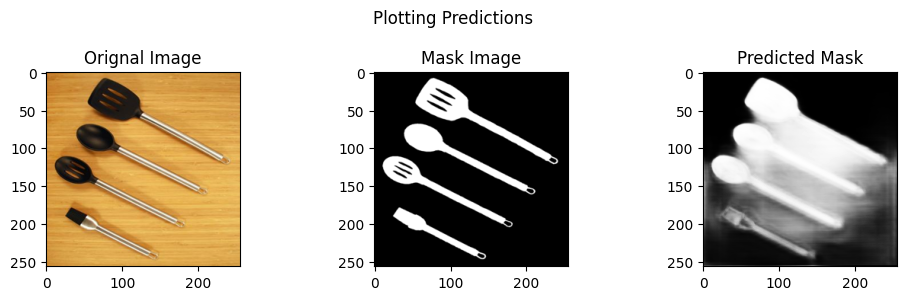

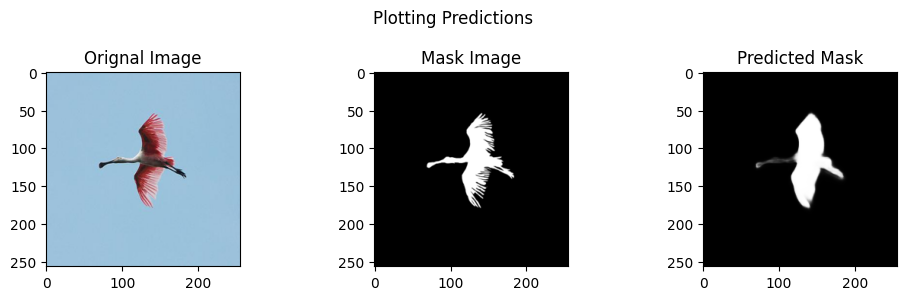

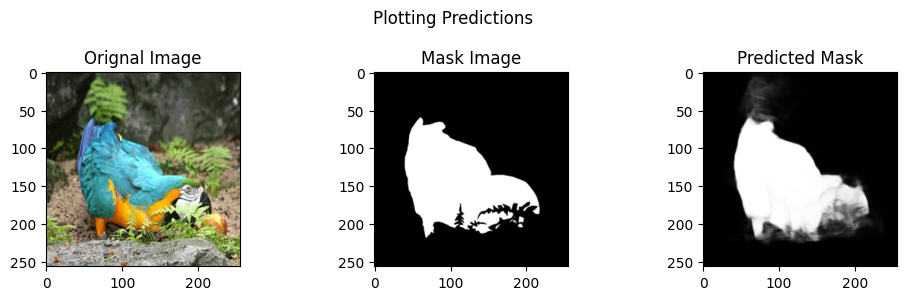

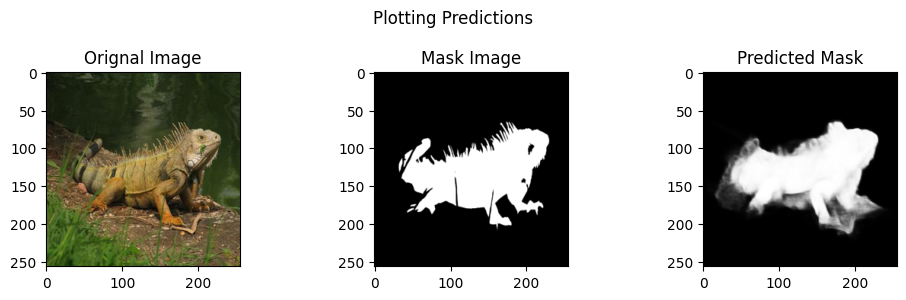

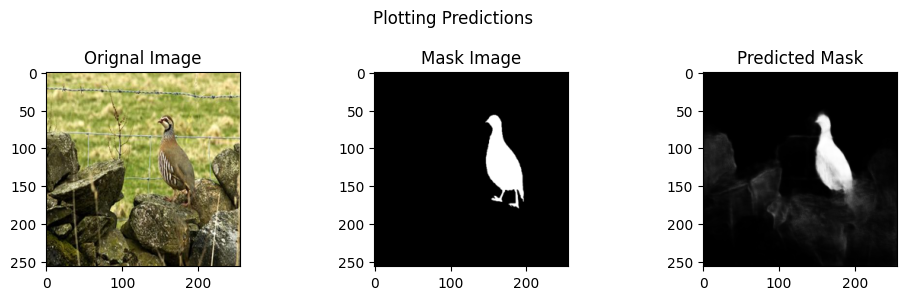

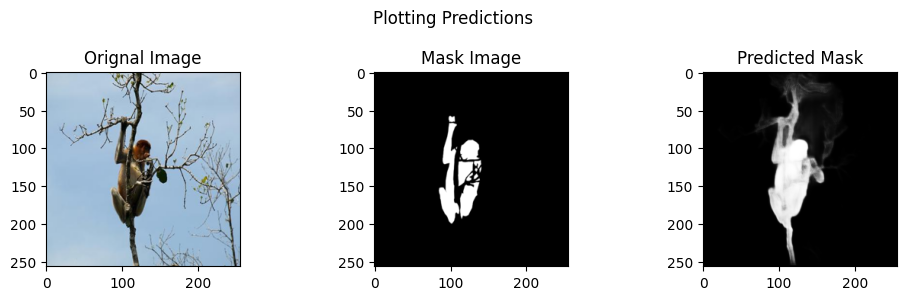

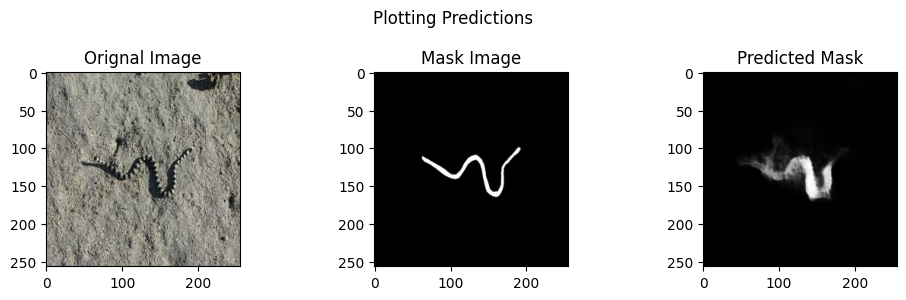

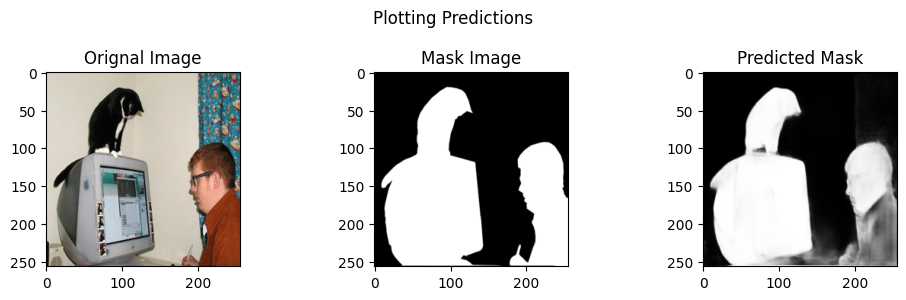

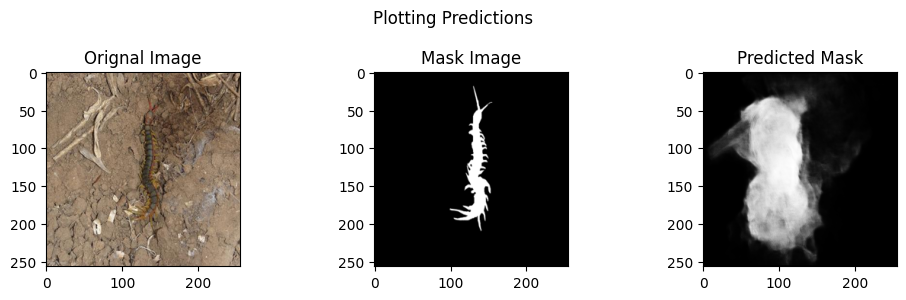

In [27]:
img=[5,39,66,25,89,115,128,154,178,182]
for i in img:
    y_pred = u2net_model.predict(np.reshape(X_test_images[i],(1,CFG.imageSize,CFG.imageSize,3)))
    plot(X_test_images[i],y_test_images[i],y_pred[0])



## test_images-outside dataset

In [29]:
paths = [
    '/kaggle/input/test-images/test_image_1',
    '/kaggle/input/test-images/test_image_2.png',
    '/kaggle/input/test-images/test_image_3.png'
]


In [30]:
def preprocess_image(image_path, size):
    """Load and preprocess an image."""
    img = Image.open(image_path).convert('RGB')
    img = img.resize((size, size))
    img_array = np.array(img)
    return np.expand_dims(img_array, axis=0)

In [31]:
def plot_image_and_prediction(original_image, predicted_mask):
    """Plot the original image and its predicted mask."""
    plt.figure(figsize=(10, 5))
    
    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')
    
    # Plot the predicted mask
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')
    
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


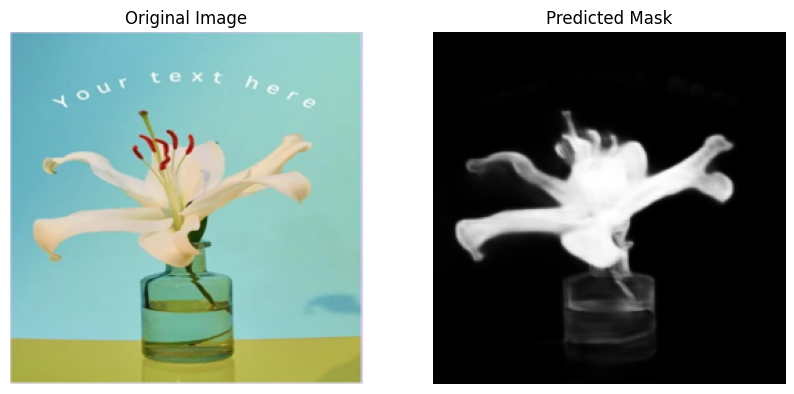

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


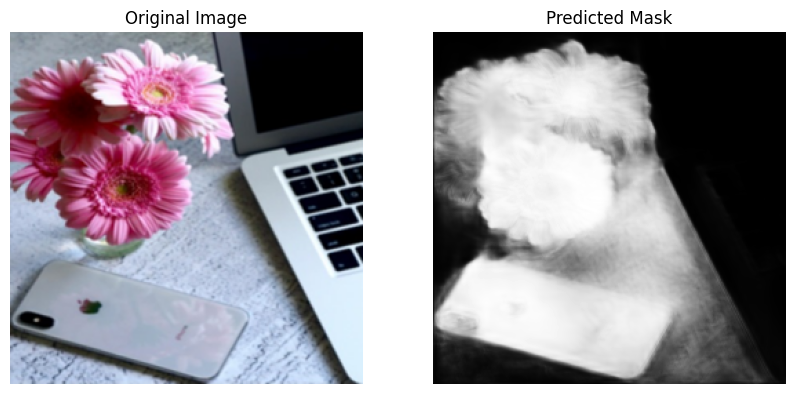

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


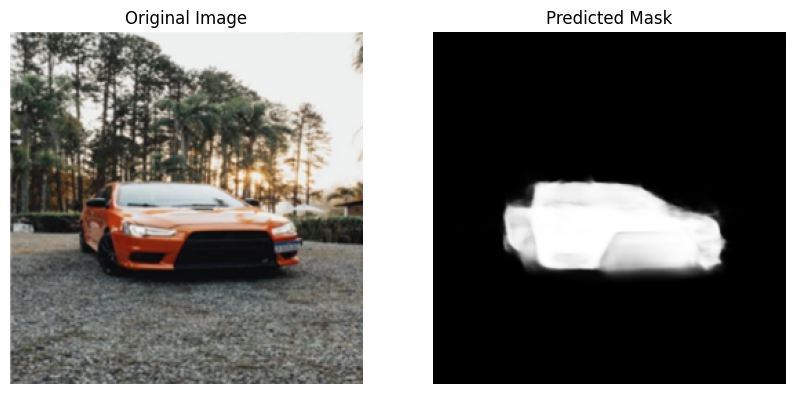

In [32]:
for path in paths:
    
    input_array = preprocess_image(path, CFG.imageSize)
    
    try:
        
        y_pred = u2net_model.predict(input_array)
        predicted_mask = y_pred[0]  # Assuming y_pred is in the format (1, height, width, channels)
        
        
        original_image = Image.open(path).resize((CFG.imageSize, CFG.imageSize))
        original_image = np.array(original_image)
        
        
        plot_image_and_prediction(original_image, predicted_mask)
    
    except Exception as e:
        print(f"Error during prediction for {path}: {e}")